# Demand Forecast: ARIMA Model

/var/folders/x4/_l78dvs92m346fbfkb6pl1h40000gn/T/ipykernel_88279/3886827639.py:9: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.10/lib/pyth

Best ARIMA order: (5, 1, 3) with AIC: 3814.6180648499712


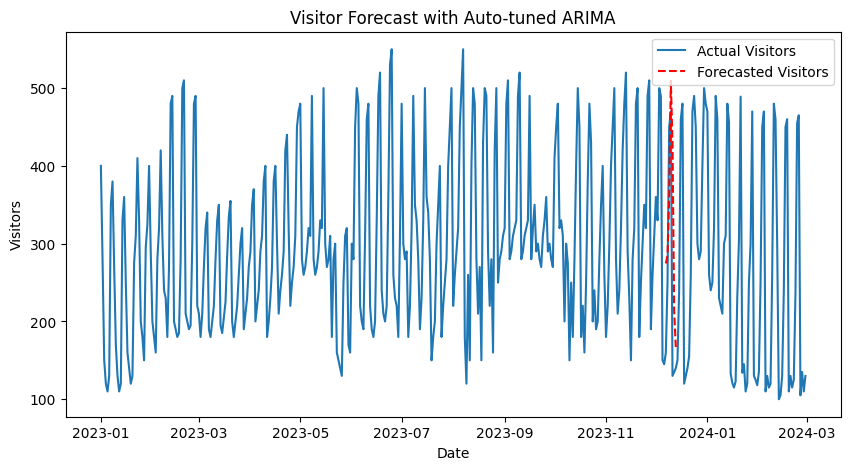

Forecasted Visitors for the next 7 days:
2023-12-07: 274.56
2023-12-08: 284.73
2023-12-09: 359.21
2023-12-10: 509.33
2023-12-11: 429.12
2023-12-12: 213.45
2023-12-13: 167.05


In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pickle
import itertools
import warnings
from kerastuner.tuners import RandomSearch

In [ ]:


def prepare_data(visitor_data_path, weather_data_path, holiday_data_path):
    visitor_data = pd.read_csv("../data/raw/synthetic_visit_data.csv")
    visitor_data['visit_date'] = pd.to_datetime(visitor_data['visit_date'])

    weather_data = pd.read_csv("../data/processed/weather_data_cleaned.csv")
    weather_data['Date'] = pd.to_datetime(weather_data['Date'])
    weather_data.drop(columns=weather_data.columns[0:3], inplace=True)

    holiday_data = pd.read_csv("../data/raw/date_info_2324.csv")
    holiday_data['calendar_date'] = pd.to_datetime(holiday_data['calendar_date'])
    holiday_data.rename(columns={'calendar_date': 'calender_date'}, inplace=True)
    holiday_data.drop(columns="day_of_week", inplace=True)

    merged_data = pd.merge(visitor_data, weather_data, left_on='visit_date', right_on='Date', how='left')
    merged_data = pd.merge(merged_data, holiday_data, left_on='visit_date', right_on='calender_date', how='left')
    merged_data.drop(columns=["Date", "calender_date"], inplace=True)

    df = pd.get_dummies(merged_data, columns=['day_of_week'])
    df['heavy_rainfall_flg'] = (df['Daily Rainfall Total (mm)'] > 20).astype(int)
    df['temperature_category'] = pd.cut(df['Mean Temperature (°C)'],
                                        bins=[-np.inf, 15, 25, np.inf],
                                        labels=['cold', 'mild', 'hot'])
    df['is_holiday'] = df[['holiday_flg_sg', 'holiday_flg_cn', 'holiday_flg_in']].max(axis=1)
    df['week_of_year'] = df['visit_date'].dt.isocalendar().week
    df = pd.get_dummies(df, columns=['temperature_category'])
    df.drop(columns=["Daily Rainfall Total (mm)", "Mean Temperature (°C)", "holiday_flg_sg", "holiday_flg_cn", "holiday_flg_in"], inplace=True)

    return df

def auto_tune_arima(train_data, p_range, d_range, q_range, seasonal=False):
    """
    Automatically tunes the ARIMA parameters based on the lowest AIC.
    
    Parameters:
    - train_data: The training data series.
    - p_range: Range of values for the AR parameter.
    - d_range: Range of values for the differencing parameter.
    - q_range: Range of values for the MA parameter.
    - seasonal: If True, will use SARIMA (Seasonal ARIMA).
    
    Returns:
    - A tuple of the best model and its parameters.
    """
    best_aic = float("inf")
    best_order = None
    best_model = None
    
    for p in p_range:
        for d in d_range:
            for q in q_range:
                if seasonal:
                    # For seasonal, you can extend this to include seasonal order
                    pass
                else:
                    try:
                        model = ARIMA(train_data, order=(p, d, q))
                        results = model.fit()
                        if results.aic < best_aic:
                            best_aic = results.aic
                            best_order = (p, d, q)
                            best_model = results
                    except Exception as e:
                        continue

    print(f"Best ARIMA order: {best_order} with AIC: {best_aic}")
    return best_model, best_order

def forecast_visitors_arima(df, forecast_days=7):
    # Ensure 'df' is sorted by date if not already
    df.sort_values('visit_date', inplace=True)
    
    # Assuming 'visitors' is your target variable and exists in 'df'
    # Convert 'visit_date' to datetime index (if not already done)
    df.set_index('visit_date', inplace=True)
    train_data, _ = train_test_split(df['visitors'], test_size=0.2, shuffle=False)
    
    # Tune the ARIMA parameters (p, d, q ranges are examples, adjust as needed)
    p_range = range(0, 6)
    d_range = range(0, 6)
    q_range = range(0, 6)
    best_model, best_order = auto_tune_arima(train_data, p_range, d_range, q_range)
    
    # Forecast using the best model
    forecast = best_model.forecast(steps=forecast_days)
    
    # Generate future dates starting the day after the last date in 'train_data'
    last_date = train_data.index[-1]
    future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=forecast_days)
    
    # Plotting
    plt.figure(figsize=(10, 5))
    plt.plot(df['visitors'], label='Actual Visitors')
    plt.plot(future_dates, forecast, label='Forecasted Visitors', linestyle='--', color='red')
    plt.title('Visitor Forecast with Auto-tuned ARIMA')
    plt.xlabel('Date')
    plt.ylabel('Visitors')
    plt.legend()
    plt.show()

    # Printing forecast values
    print("Forecasted Visitors for the next 7 days:")
    for date, value in zip(future_dates, forecast):
        print(f"{date.date()}: {value:.2f}")

    return forecast

# Example usage
# Ensure you replace 'path_to_your_data.csv' with the actual path to your CSV files
df = prepare_data('path_to_synthetic_visit_data.csv', 'path_to_weather_data_cleaned.csv', 'path_to_date_info_2324.csv')
forecast = forecast_visitors_arima(df, 7)

# Load and use the saved model
#model_fit = pickle.load(open('visitor_forecast_arima_model.pkl', 'rb'))
#new_forecast = model_fit.forecast(steps=7)
